<style>
body {
    font-size: 20pt !important;
}

.rendered_html {
    font-size: 20pt !important;
}

.CodeMirror pre {
    font-size: 20pt !important;
}

.output pre {
    font-size: 20pt !important;
}
</style>


<h2 style="font-size:24pt"> Proyecto DESI</h2>

<h2 style="font-size:24pt"> Julio 4, 2025</h2>

<p style="font-size:16pt">
Calculation of the parameter r, classfication of the data, count fraction of the classification and cumulative probability distribution

In [45]:
import numpy as np
import matplotlib.tri as mtri
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import ascii
import pandas as pd
import networkx as nx
import scipy
import seaborn as sns
from scipy.stats import norm

## Data

In [2]:
rosettes = list(range(20))
data = {}
rand = {}

for i, number_rosette in enumerate(rosettes):
    file = f"data_rosette/LRG_{number_rosette}_clustering_data.ecsv"
    table = Table.read(file, format="ascii.ecsv") 
    subset = table[['TARGETID','RA', 'DEC', 'Z','x','y','z']].to_pandas()
    data[f"data_{i}"] = subset

for i, number_rosette in enumerate(rosettes):
    file = f"data_rosette/LRG_{number_rosette}_clustering_rand.ecsv"
    table = Table.read(file, format="ascii.ecsv")
    subset = table[['TARGETID','RA', 'DEC', 'Z','x','y','z']].to_pandas()
    rand[f"rand_{i}"] = subset

## Concatenation

In [3]:
data_all = {}

for name, table in data.items():
    table['type'] = 'data'

for name, table in rand.items():
    table['type'] = 'rand'

for i, number_rosette in enumerate(rosettes):
    data_all[f"rosette_{i}"] = pd.concat([data[f"data_{i}"],rand[f"rand_{i}"]])

## Parameter r

In [4]:
def parameter_r(data_all):
    df_tri = data_all[['x', 'y', 'z']]
    tri = Delaunay(df_tri)
    
    G = nx.Graph()
    for i, row in df_tri.iterrows():
        G.add_node(i, pos=(row['x'], row['y'], row['z']))
    
    #Simplices: Indices of the points forming the simplices in the triangulation.
    for simplex in tri.simplices:
        for i in range(3):
            for j in range(i + 1, 4): 
                G.add_edge(simplex[i], simplex[j]) #Add the connections between the nodes.
    
    #Label de points according to the type of data
    for i, tipo in enumerate(data_all['type']):
        G.nodes[i]['type'] = tipo

    #Add column with the degree of the network
    connections = dict(G.degree())

    for index, row in data_all.iterrows():
        connection = connections[index]
        data_all.loc[index, 'degree'] = connection

    #Add columns with the count of each type of connection (whether it is real or not).
    n_data = []
    n_random = []
    
    for i in G.nodes:
        real = 0
        random = 0
        for neighbor in G.neighbors(i):
            tipo = G.nodes[neighbor]['type']
            if tipo == 'data':
                real += 1
            elif tipo == 'rand':
                random += 1
        
        n_data.append(real)
        n_random.append(random)
    
    data_all['N_data'] = n_data
    data_all['N_random'] = n_random

    #Definition of r
    data_all['r'] = (data_all['N_data']-data_all['N_random'])/(data_all['N_data']+data_all['N_random'])

In [5]:
for rosette, table in data_all.items():
    parameter_r(table)

In [6]:
data_all['rosette_0'].sort_values('z')

,TARGETID,RA,DEC,Z,x,y,z,type,degree,N_data,N_random,r
4844,39627799325052694,150.192314,0.514613,0.434181,-1493.102942,855.374129,15.455771,data,18.0,5,13,-0.444444
4907,327858175468372845,149.546913,0.540609,0.422826,-1449.038513,851.951580,15.860746,rand,15.0,6,9,-0.200000
4838,39627799329246374,150.420605,0.536216,0.430647,-1485.741568,843.312098,15.988855,data,11.0,6,5,0.090909
3913,327858175485151150,150.544062,0.542788,0.432226,-1492.368228,842.826949,16.237187,rand,18.0,6,11,-0.294118
1394,327858175476762175,150.129459,0.579334,0.409498,-1416.782710,813.717161,16.520700,rand,13.0,10,11,-0.047619
...,...,...,...,...,...,...,...,...,...,...,...,...
5494,39627883857053393,150.294145,3.889004,1.076337,-3103.376787,1770.555164,242.888922,data,14.0,6,8,-0.142857
3177,327858260004571184,150.118342,3.922898,1.065932,-3076.347645,1767.668130,243.305480,rand,16.0,6,10,-0.250000
3818,327858260008765653,150.335226,3.961530,1.055725,-3061.651083,1743.841056,244.006317,rand,11.0,3,6,-0.333333
1422,327858260004569722,150.000730,3.908058,1.085059,-3112.067399,1796.700065,245.486577,rand,10.0,5,10,-0.333333


## Classification r

In [7]:
def classification(data):
    for index, row in data.iterrows():
        r = row['r']
        if -1 <= r <= -0.9:
            data.at[index, 'classification'] = 'void'
        elif -0.9 < r <= 0:
            data.at[index, 'classification'] = 'sheet'
        elif 0 < r <= 0.9:
            data.at[index, 'classification'] = 'filament'
        elif 0.9 < r <= 1:
            data.at[index, 'classification'] = 'knot'
    data.sort_values('z')

In [8]:
for rosette, table in data_all.items():
    classification(table)

In [9]:
def section(data):
    new_df = data.sort_values('z').copy()
    new_data = new_df.iloc[:]
    return (new_data)

In [87]:
section_data = data_all['rosette_1']

void     = section_data[section_data['classification'] == 'void']
sheet    = section_data[section_data['classification'] == 'sheet']
filament = section_data[section_data['classification'] == 'filament']
knot     = section_data[section_data['classification'] == 'knot']

In [88]:
set(section_data['classification'])

{'filament', 'knot', 'sheet', 'void'}

## Visualization

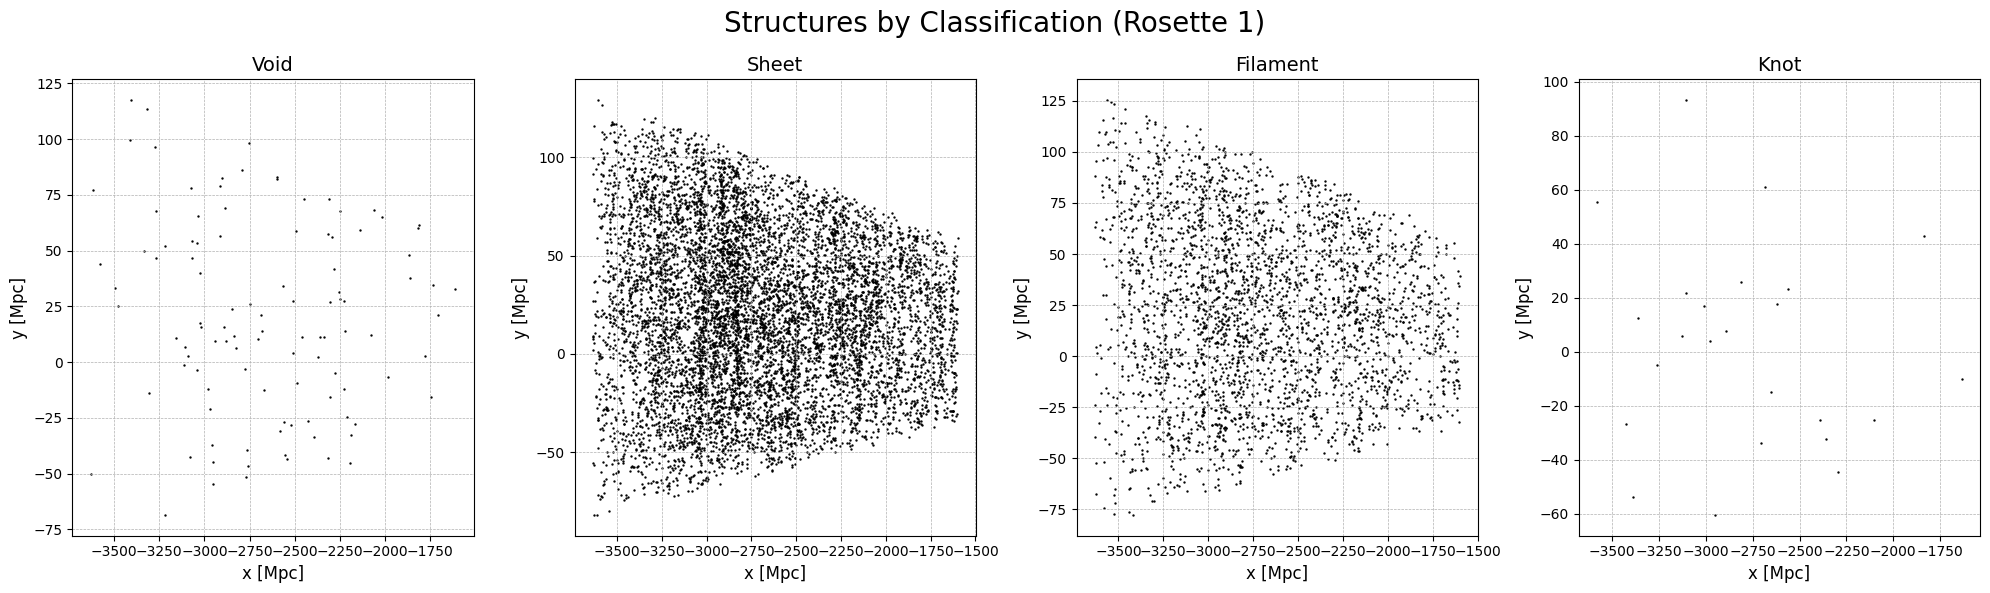

In [99]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
axes = ax.flatten()

classes = [void, sheet, filament, knot]
titles = ['Void', 'Sheet', 'Filament', 'Knot']

for i in range(4):
    axes[i].scatter(classes[i]['x'], classes[i]['y'], c='k', s=0.5)
    axes[i].set_title(titles[i], fontsize=14)
    axes[i].set_xlabel('x [Mpc]', size=12)
    axes[i].set_ylabel('y [Mpc]', size=12)
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    #axes[i].set_xlim(-2450,-2400)
    #axes[i].set_ylim(1350,1450)

fig.suptitle('Structures by Classification (Rosette 1)', fontsize=20)
plt.tight_layout()

plt.show()

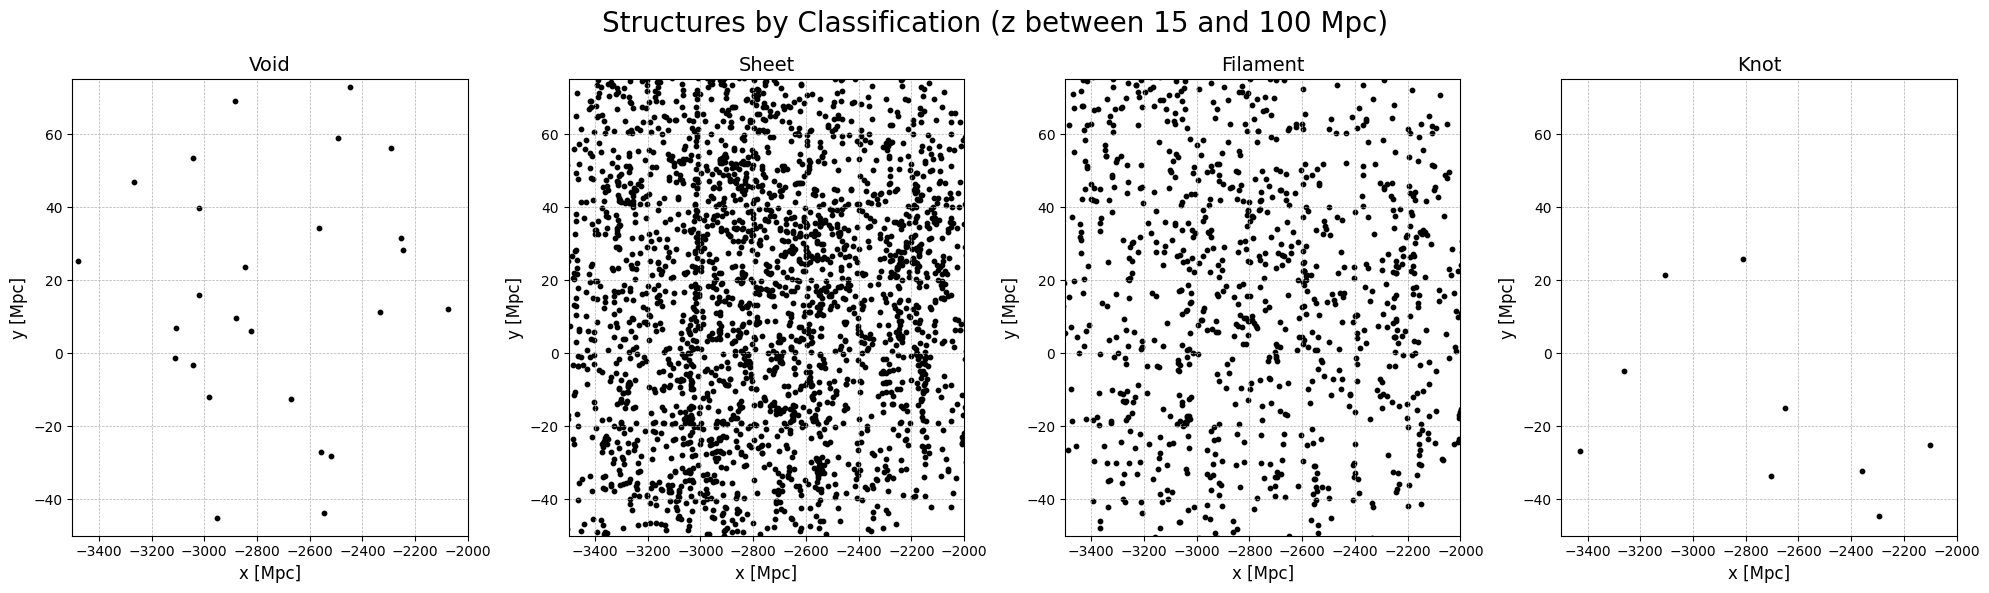

In [90]:
z_slice = (15, 100) 

fig, ax = plt.subplots(1, 4, figsize=(20, 6))
axes = ax.flatten()

classes = [void, sheet, filament, knot]
titles = ['Void', 'Sheet', 'Filament', 'Knot']

for i in range(4):
    mask_z = (classes[i]['z'] >= z_slice[0]) & (classes[i]['z'] <= z_slice[1])
    data_filtered = classes[i][mask_z]

    axes[i].scatter(data_filtered['x'], data_filtered['y'], c='k', s=10)
    axes[i].set_title(titles[i], fontsize=14)
    axes[i].set_xlabel('x [Mpc]', size=12)
    axes[i].set_ylabel('y [Mpc]', size=12)
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[i].set_xlim(-3500,-2000)
    axes[i].set_ylim(-50,75)

fig.suptitle(f'Structures by Classification (z between {z_slice[0]} and {z_slice[1]} Mpc)', fontsize=20)
plt.tight_layout()
plt.show()


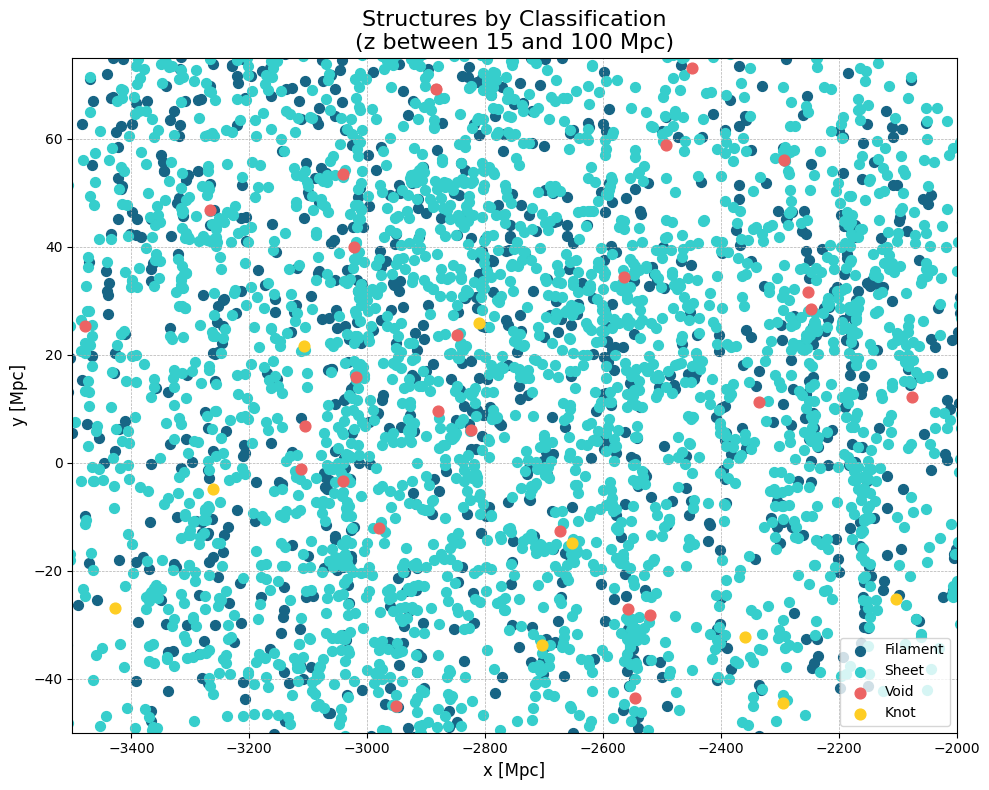

In [117]:
void_filtered = void[(void['z'] >= z_slice[0]) & (void['z'] <= z_slice[1])]
sheet_filtered = sheet[(sheet['z'] >= z_slice[0]) & (sheet['z'] <= z_slice[1])]
filament_filtered = filament[(filament['z'] >= z_slice[0]) & (filament['z'] <= z_slice[1])]
knot_filtered = knot[(knot['z'] >= z_slice[0]) & (knot['z'] <= z_slice[1])]

fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(filament_filtered['x'], filament_filtered['y'], c='#176585', s=50, label='Filament')     
ax.scatter(sheet_filtered['x'], sheet_filtered['y'], c='#36cecc', s=50, label='Sheet')             
ax.scatter(void_filtered['x'], void_filtered['y'], c='#ec6363', s=60, label='Void', zorder=3)       
ax.scatter(knot_filtered['x'], knot_filtered['y'], c='#fecd23', s=60, label='Knot', zorder=4)  




ax.set_xlabel('x [Mpc]', size=12)
ax.set_ylabel('y [Mpc]', size=12)
ax.set_title(f'Structures by Classification\n(z between {z_slice[0]} and {z_slice[1]} Mpc)', fontsize=16)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=10)
ax.set_xlim(-3500,-2000)
ax.set_ylim(-50,75)

plt.tight_layout()
plt.show()

## Count_fraction

In [118]:
count_fraction = pd.DataFrame({
    'Rosette' : 'Rosette 1',
    'Void':     [len(void)     / len(section_data) * 100],
    'Sheet':    [len(sheet)    / len(section_data) * 100],
    'Filament': [len(filament) / len(section_data) * 100],
    'Knot':     [len(knot)     / len(section_data) * 100],
})

In [119]:
count_fraction

,Rosette,Void,Sheet,Filament,Knot
0,Rosette 1,0.895422,72.44467,26.457172,0.202737


## Cumulative probabiliy distribution

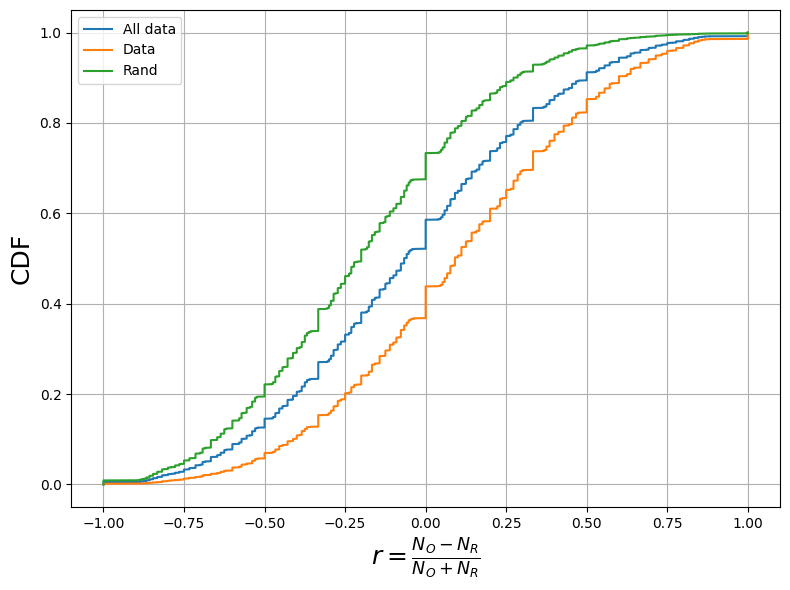

In [70]:
sort = section_data['r'].sort_values()
sort_rand = section_data[section_data['type'] == 'rand'].sort_values(by='r')
sort_data = section_data[section_data['type'] == 'data'].sort_values(by='r')

cdf = np.arange(1, len(sort)+1) / len(sort)
cdf_rand = np.arange(1, len(sort_rand['r'])+1) / len(sort_rand['r'])
cdf_data = np.arange(1, len(sort_data['r'])+1) / len(sort_data['r'])

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(sort, cdf, label='All data')
ax.plot(sort_data['r'], cdf_data, label='Data')
ax.plot(sort_rand['r'], cdf_rand, label='Rand')

ax.set_xlabel(r'$r = \frac{N_O - N_R}{N_O + N_R}$', fontsize=18)
ax.set_ylabel('CDF', fontsize=18)
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()
